<a href="https://colab.research.google.com/github/myaqueenas/LuxuryBrand-DeepLearning-/blob/main/test_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import shutil

import pathlib
import PIL
from PIL import Image

import cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tqdm.notebook import tqdm

import time
import datetime

In [ ]:
img_save_root = '/content/gdrive/MyDrive/data/front_c_images2'

In [ ]:
data_dir = pathlib.Path(img_save_root)
print('data_dir:::', data_dir)

image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print('image_count:::', image_count)

data_dir::: /content/gdrive/MyDrive/data/front_c_images2
image_count::: 7276


In [ ]:
batch_size = 32*2
img_height = 229
img_width = 229
IMG_SIZE = (img_height, img_width)

# 학습 데이터 로드
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size)

# 검증 데이터 로드
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size)    

# 검증 데이터 검증/테스트 데이터로 분리
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

# 클래스 종류 확인
class_names = train_dataset.class_names
print('class_names:::', class_names)

num_classes = len(class_names)
print('num_classes:::', num_classes)

# summary
print('_'*10)
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 7276 files belonging to 8 classes.
Using 5821 files for training.
Found 7276 files belonging to 8 classes.
Using 1455 files for validation.
class_names::: ['BCKTB', 'BLTB', 'BPK', 'CLTCH', 'SHDRB', 'TOTEB', 'TSHB', 'WALLETS']
num_classes::: 8
__________
Number of train batches: 91
Number of validation batches: 12
Number of test batches: 11


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
# 멀티 GPU 설정 안에서 모델 컴파일
with mirrored_strategy.scope():
    ######################################################################
    # Pre-Processing
    # -------- 데이터 증강
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        # tf.keras.layers.experimental.preprocessing.RandomCrop(height=int(img_height), width=int(img_width), seed=123),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.3, width_factor=0.3, fill_mode='constant',
            interpolation='bilinear', seed=123, fill_value=1.0),
        tf.keras.layers.GaussianNoise(stddev=0.1),
    ])
    # -------- 스케일 조정(0 ~ 255 --> 0.0 ~ 1.0 등등)
    # preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
    
    ######################################################################
    # Feature Extractor
    # -------- pre-trained 모델 로드
    IMG_SHAPE = IMG_SIZE + (3,)
#     base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                    include_top=False,
#                                                    weights='imagenet')
    
    base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    
    print("Number of layers in the base model: ", len(base_model.layers))
    
    # feature extractor 부분 학습 안하도록 설정  
    base_model.trainable = False
    
    #### 1st 학습때부터 파인튜닝
    ## 동결된 모델(feature extractor 부분)과 커스텀 레이어의 영역을 적절히 선택하여 학습시키기 ##
    base_model.trainable = True
    print("Number of layers in the base model: ", len(base_model.layers))
    # Fine-tune from this layer onwards
    fine_tune_at = 520
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
    ####
    
    ######################################################################
    # FNC / classifier
    # -------- GAP
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # -------- Softmax Layer
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    
    ######################################################################
    # 커스텀 모델 조립
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0003 #  0.0001 원래값
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 229, 229, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 229, 229, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 229, 229, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 229, 229, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [ ]:
# epochs
initial_epochs = 40

In [ ]:
## 시간 측정 시작 ##
start_now = time.localtime()
initialTime = time.time()

#
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# ----------- tensorboard
# 결과 로그 경로
log_dir = f'./logs_{time_stamp}/fit/{time_stamp}'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
# tensorboard 콜백 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# ----------- checkpoint
# checkpoint 경로
prefix_path = f'./logs_{time_stamp}/ckpt/training-{time_stamp}'
checkpoint_path = os.path.join(prefix_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)
# 체크포인트 콜백
cp_per = initial_epochs / 2
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=cp_per)

# 초기 가중치 저장
model.save_weights(checkpoint_path.format(epoch=0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback, cp_callback])

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


91/91 [==============================] - 1099s 11s/step - loss: 0.8365 - accuracy: 0.7329 - val_loss: 0.5326 - val_accuracy: 0.8269
Epoch 2/40
91/91 [==============================] - 85s 876ms/step - loss: 0.5297 - accuracy: 0.8222 - val_loss: 0.4865 - val_accuracy: 0.8415
Epoch 3/40
91/91 [==============================] - 81s 838ms/step - loss: 0.4185 - accuracy: 0.8584 - val_loss: 0.4799 - val_accuracy: 0.8615
Epoch 4/40
91/91 [==============================] - 81s 839ms/step - loss: 0.3551 - accuracy: 0.8882 - val_loss: 0.4410 - val_accuracy: 0.8722
Epoch 5/40
91/91 [==============================] - 81s 847ms/step - loss: 0.2859 - accuracy: 0.9062 - val_loss: 0.3515 - val_accuracy: 0.8908
Epoch 6/40
91/91 [==============================] - 81s 842ms/step - loss: 0.2409 - accuracy: 0.9193 - val_loss: 0.4563 - val_accuracy: 0.8695
Epoch 7/40
91/91 [==============================] - 81s 844ms/step - loss: 0.2307 - accuracy: 0.9249 - val_loss: 0.3940 - val_accuracy: 0.8908
Epoch 8/40

In [ ]:
## 시간 측정 끝 ##

# 시작 시간 스탬프
print("Training 1st Start at %04d/%02d/%02d %02d:%02d:%02d" % \
      (start_now.tm_year, start_now.tm_mon, start_now.tm_mday, start_now.tm_hour, start_now.tm_min, start_now.tm_sec))

end_now = time.localtime()
print("Training 1st End at %04d/%02d/%02d %02d:%02d:%02d" % \
      (end_now.tm_year, end_now.tm_mon, end_now.tm_mday, end_now.tm_hour, end_now.tm_min, end_now.tm_sec))

elapsed_time_1st = round(time.time() - initialTime, 4)
cal_time_easy = str(datetime.timedelta(seconds=elapsed_time_1st))
try:
    cal_time_easy = cal_time_easy.split('.')[0]
except:
    pass

print('Training 1st takes', cal_time_easy)

Training 1st Start at 2021/07/08 05:23:41
Training 1st End at 2021/07/08 06:38:14
Training 1st takes 1:14:32


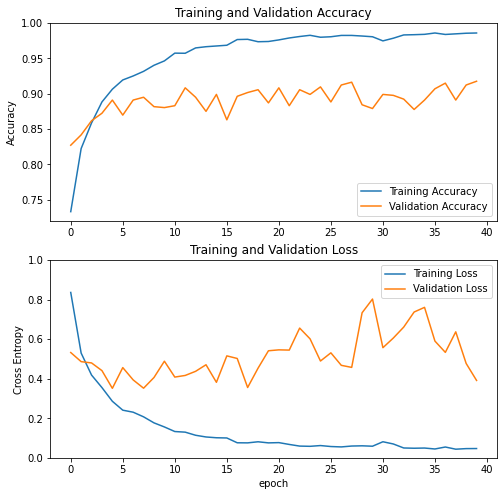

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
initial_epochs# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')

# plt.legend(loc='right')
# plt.ylabel('Accuracy & Loss')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy & Loss')

# plt.xlabel('epoch')
# plt.show()

40

In [ ]:
## 동결된 모델(feature extractor 부분)과 커스텀 레이어의 영역을 적절히 선택하여 학습시키기 ##

base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 520

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  780


In [ ]:
# 멀티 GPU 설정 안에서 모델 컴파일
with mirrored_strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f8d75d2ef90>>

In [ ]:
## 시간 측정 시작 ##
start_now = time.localtime()
initialTime = time.time()

fine_tune_epochs = 80
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[tensorboard_callback, cp_callback])

Epoch 40/120


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


91/91 [==============================] - 103s 918ms/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.5998 - val_accuracy: 0.9188
Epoch 41/120
91/91 [==============================] - 81s 837ms/step - loss: 0.0226 - accuracy: 0.9926 - val_loss: 0.5095 - val_accuracy: 0.9254
Epoch 42/120
91/91 [==============================] - 81s 838ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 0.6602 - val_accuracy: 0.9201
Epoch 43/120
91/91 [==============================] - 81s 839ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.6168 - val_accuracy: 0.9214
Epoch 44/120
91/91 [==============================] - 81s 844ms/step - loss: 0.0133 - accuracy: 0.9964 - val_loss: 0.4954 - val_accuracy: 0.9254
Epoch 45/120
91/91 [==============================] - 81s 838ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.5799 - val_accuracy: 0.9188
Epoch 46/120
91/91 [==============================] - 81s 839ms/step - loss: 0.0130 - accuracy: 0.9952 - val_loss: 0.6626 - val_accuracy: 0.91

In [ ]:
## 시간 측정 끝 ##

# 시작 시간 스탬프
print("Training 2nd Start at %04d/%02d/%02d %02d:%02d:%02d" % \
      (start_now.tm_year, start_now.tm_mon, start_now.tm_mday, start_now.tm_hour, start_now.tm_min, start_now.tm_sec))

end_now = time.localtime()
print("Training 2nd End at %04d/%02d/%02d %02d:%02d:%02d" % \
      (end_now.tm_year, end_now.tm_mon, end_now.tm_mday, end_now.tm_hour, end_now.tm_min, end_now.tm_sec))

elapsed_time_2nd = round(time.time() - initialTime, 4)
cal_time_easy = str(datetime.timedelta(seconds=elapsed_time_2nd))
try:
    cal_time_easy = cal_time_easy.split('.')[0]
except:
    pass

print('Training 2nd takes', cal_time_easy)

Training 2nd Start at 2021/07/08 06:39:22
Training 2nd End at 2021/07/08 08:40:08
Training 2nd takes 2:00:45


In [ ]:
cal_time_easy = str(datetime.timedelta(seconds=elapsed_time_1st+elapsed_time_2nd))
try:
    cal_time_easy = cal_time_easy.split('.')[0]
except:
    pass

print('Training Total takes', cal_time_easy)

Training Total takes 3:15:18


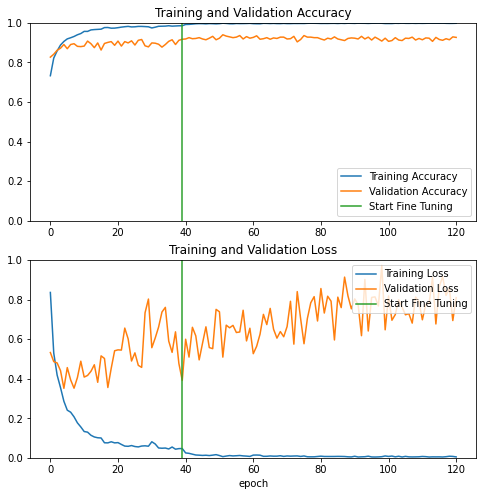

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

11/11 [==============================] - 13s 726ms/step - loss: 0.7057 - accuracy: 0.9261
Test accuracy : 0.9261363744735718


In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)
# 확률 제일 큰 값과 인덱스 찾기
predictions_max_val = np.max(predictions, axis=1)  # 최대값(==확률)
predictions_max_val_idx = np.argmax(predictions, axis=1)  # 인덱스(==클래스 순번)

In [ ]:
# 맞춘 항목 확인
result_chk = label_batch - predictions_max_val_idx
result_chk = tf.where(result_chk == 0, 1, 0)

print('Predictions:\n', predictions_max_val_idx)
print('Labels:\n', label_batch)
print('result_chk:\n', result_chk.numpy())

Predictions:
 [4 4 5 3 4 5 4 6 6 6 4 6 4 4 4 6 4 4 7 6 4 4 1 2 6 5 4 4 4 6 4 2 6 6 6 4 6
 4 6 6 4 6 6 6 4 6 3 4 3 6 4 4 7 7 4 4 4 6 6 6 6 3 6 4]
Labels:
 [4 4 5 3 4 5 4 4 6 6 4 6 4 4 4 6 4 4 7 6 4 4 1 2 6 5 4 4 4 6 4 2 6 6 6 4 6
 4 6 6 4 6 6 6 4 6 3 4 3 6 4 4 7 7 4 4 4 4 6 6 4 7 6 4]
result_chk:
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]


complete!!!


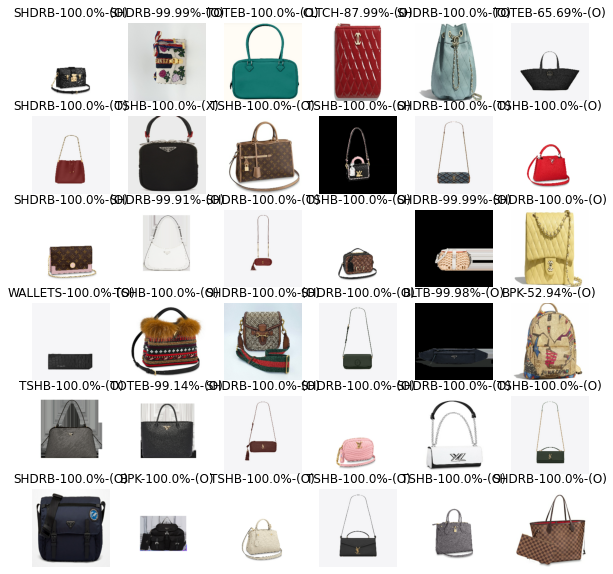

In [ ]:
row_size = 6
col_size = 6
num_item = row_size * col_size

plt.figure(figsize=(10, 10))
for i in range(num_item):
    ax = plt.subplot(row_size, col_size, i + 1)
    
    try:
        fig_img = image_batch[i]
    except IndexError:
        pass
    else:
        plt.imshow(fig_img.astype("uint8"))

        pred_cls_name = class_names[predictions_max_val_idx[i]]
        pred_cls_pernt = round(predictions_max_val[i] * 100, 2)
        real_cls_name = class_names[label_batch[i]]

        if result_chk[i] == 1:
            is_crrt_answ = 'O'
        elif result_chk[i] == 0:
            is_crrt_answ = 'X'

        plt.title(pred_cls_name + '-' + f'{pred_cls_pernt}%' + '-' + f'({is_crrt_answ})')
    plt.axis("off")

    
print('complete!!!')

In [ ]:
# 모델 저장
md_save_dir = f'./logs_{time_stamp}/saved_model'
if not os.path.exists(md_save_dir):
    os.makedirs(md_save_dir)
    
md_save_path = os.path.join(md_save_dir, f'{time_stamp}.h5')

model.save(md_save_path)

In [ ]:
from keras.preprocessing import image

Predictions:
 [4]
img name::: /content/gdrive/MyDrive/data/1c3c3958afa348a5accb33bbdfa6823a1620713359.jpg
complete!!!


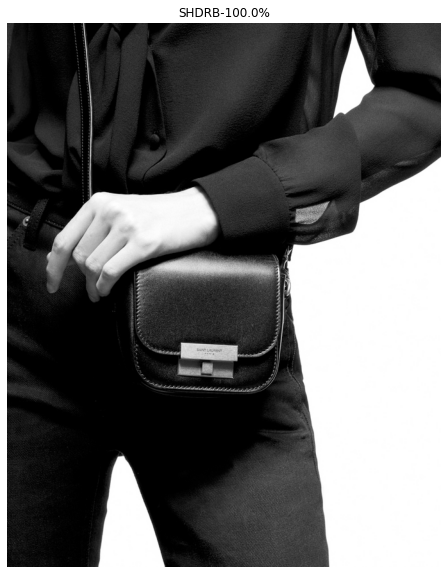

In [ ]:
# 소스 로드
# excloset_im_pa = '/content/gdrive/MyDrive/data/1.png'
excloset_im_pa = '/content/gdrive/MyDrive/data/1c3c3958afa348a5accb33bbdfa6823a1620713359.jpg'
# excloset_im_pa = '/content/gdrive/MyDrive/data/A_02_01228_01_6.jpg'

img = image.load_img(excloset_im_pa, target_size=IMG_SIZE)
img = image.img_to_array(img)

img = np.expand_dims(img, axis = 0)

# 예측
predictions = model.predict(img)
predictions_max_val = np.max(predictions, axis=1)  # 최대값(==확률)
predictions_max_val_idx = np.argmax(predictions, axis=1)  # 인덱스(==클래스 순번)

print('Predictions:\n', predictions_max_val_idx)
print('img name:::', excloset_im_pa)

plt.figure(figsize=(10, 10))
for i in range(1):
    ax = plt.subplot(1, 1, i + 1)
    
    fig_img = PIL.Image.open(excloset_im_pa)
    plt.imshow(fig_img)

    pred_cls_name = class_names[predictions_max_val_idx[i]]
    pred_cls_pernt = round(predictions_max_val[i] * 100, 2)
    plt.title(pred_cls_name + '-' + f'{pred_cls_pernt}%')
    plt.axis("off")

    
print('complete!!!')